# Metaflow - nested foreach
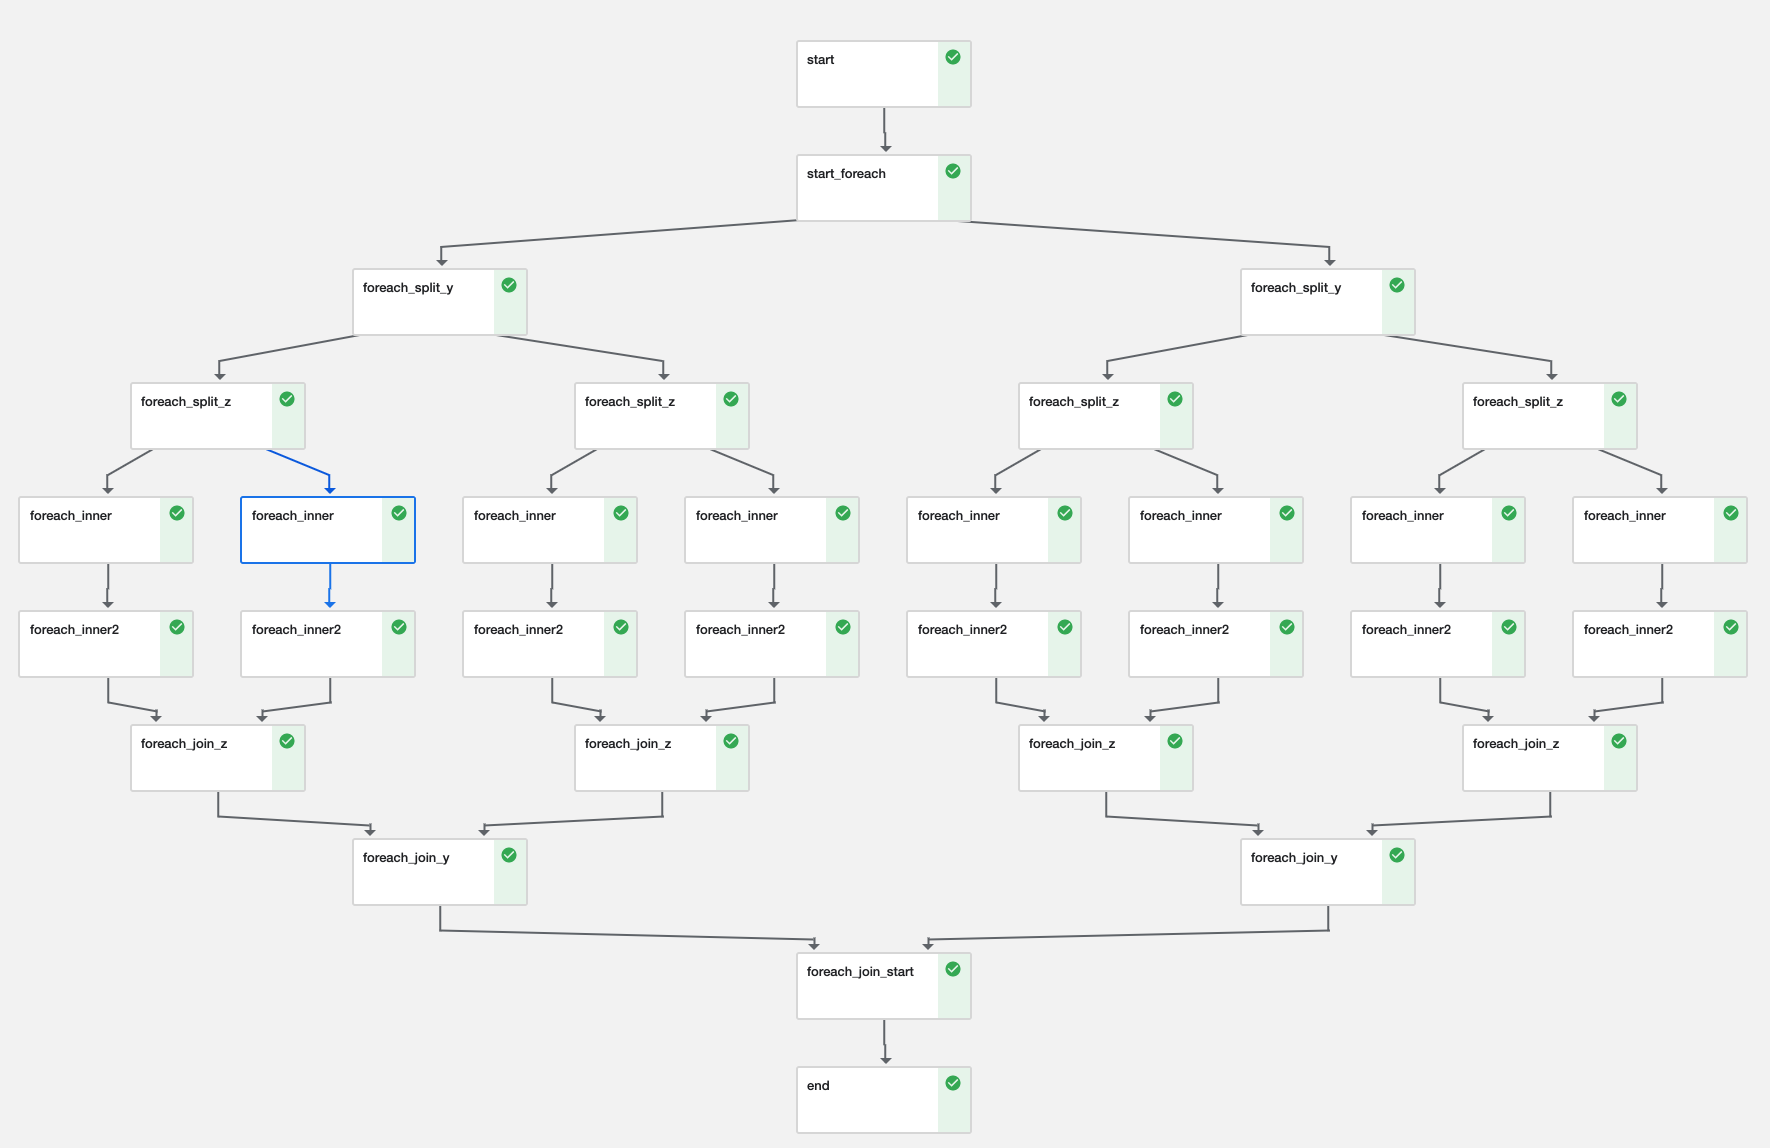

In [ ]:
!pip install -e 'git+https://github.com/zillow/metaflow.git@tz/foreach#egg=metaflow'

In [1]:
%%writefile ~/.metaflowconfig/config.json 
{
        "KFP_RUN_URL_PREFIX": "https://kubeflow.corp.dev.zg-aip.net/",
        "KFP_SDK_NAMESPACE": "aip-example",
        "METAFLOW_DATASTORE_SYSROOT_S3": "s3://aip-example-dev/metaflow",
        "METAFLOW_DEFAULT_DATASTORE": "local",
        "METAFLOW_USER": "talebz@zillowgroup.com"
}


Overwriting /home/zservice/.metaflowconfig/config.json


In [5]:
%%writefile nested_foreach.py

# -*- coding: utf-8 -*-
from metaflow import FlowSpec, step, Parameter, JSONType
import pprint


def truncate(var):
    var = str(var)
    if len(var) > 500:
        var = '%s...' % var[:500]
    return var



class ExpectationFailed(Exception):

    def __init__(self, expected, got):
        super(ExpectationFailed, self).__init__("Expected result: %s, got %s"\
                                                % (truncate(expected),
                                                   truncate(got)))

def assert_equals(expected, got):
    if expected != got:
        raise ExpectationFailed(expected, got)


class NestedForeachTestFlow(FlowSpec):
    @step
    def start(self):
        self.my_var = 'ab'
        self.x = 'ab'
        self.next(self.start_foreach)
    @step
    def start_foreach(self):
        pprint.pprint(self.my_var)
        self.next(self.foreach_split_y, foreach="x")
    @step
    def foreach_split_y(self):
        self.y = 'cd'
        self.next(self.foreach_split_z, foreach="y")
    @step
    def foreach_split_z(self):
        self.z = 'ef'
        self.next(self.foreach_inner, foreach="z")
    @step
    def foreach_inner(self):
        pprint.pprint(self.input)
        [x, y, z] = self.foreach_stack()
        
        # assert that lengths are correct
        assert_equals(len(self.x), x[1])
        assert_equals(len(self.y), y[1])
        assert_equals(len(self.z), z[1])
        
        # assert that variables are correct given their indices
        assert_equals(x[2], self.x[x[0]])
        assert_equals(y[2], self.y[y[0]])
        assert_equals(z[2], self.z[z[0]])
        
        self.combo = x[2] + y[2] + z[2]
        self.next(self.foreach_inner2)

    @step
    def foreach_inner2(self):
        pprint.pprint(self.my_var)
        self.next(self.foreach_join_z)

    @step
    def foreach_join_z(self, inputs):
        self.merge_artifacts(inputs, exclude="combo")
        pprint.pprint(self.my_var)
        pprint.pprint([(input.x, input.y, input.z) for input in inputs])
        self.next(self.foreach_join_y)
    @step
    def foreach_join_y(self, inputs):
        self.merge_artifacts(inputs) #, exclude="combo")
        pprint.pprint([x for x in inputs])
        self.next(self.foreach_join_start)
    @step
    def foreach_join_start(self, inputs):
        self.merge_artifacts(inputs) #, exclude="combo")
        pprint.pprint([x for x in inputs])
        self.next(self.end)
    @step
    def end(self):
        pprint.pprint(self.my_var)
        pprint.pprint(self.y)
        pprint.pprint(self.z)
        pass
if __name__ == '__main__':
    NestedForeachTestFlow()


Writing nested_foreach.py


In [8]:
!python nested_foreach.py --datastore=s3 kfp run

Metaflow 2.0.5.post169+git03a9188 executing NestedForeachTestFlow for user:talebz@zillowgroup.com
Validating your flow...
    The graph looks good!
Running pylint...
    Pylint is happy!
Uploaded package to: s3://aip-example-dev/metaflow/NestedForeachTestFlow/data/46/466316a5c0bf69cb3cbf81d14ae60ae5f6a19a1c
Deploying NestedForeachTestFlow to Kubeflow Pipelines...

Run created successfully!

Metaflow run_id=kfp-3e327877-6aef-4d2d-90f7-e27b1e3e24c3 

Run link: https://kubeflow.corp.dev.zg-aip.net/_/pipeline/#/runs/details/3e327877-6aef-4d2d-90f7-e27b1e3e24c3



## step_kfp_output paths and contents
Notice how that the `passed_in_split_indexes` become the taskIds if the Metaflow node `is_inside_foreach`

```python
if is inside foreach:
  f"s3://flow_root>/step_kfp_outputs/{task_id}.{node.name}.json"
else 
  f"s3://flow_root>/step_kfp_outputs/{node.name}.json"
```

In [2]:
!aws s3 ls s3://aip-example-dev/metaflow/NestedForeachTestFlow/kfp-3e327877-6aef-4d2d-90f7-e27b1e3e24c3/step_kfp_outputs/

2020-10-13 21:28:00         16 0.foreach_join_y.json
2020-10-13 21:26:53         50 0.foreach_split_y.json
2020-10-13 21:27:44         18 0_0.foreach_join_z.json
2020-10-13 21:27:05         56 0_0.foreach_split_z.json
2020-10-13 21:27:17         20 0_0_0.foreach_inner.json
2020-10-13 21:27:29         20 0_0_0.foreach_inner2.json
2020-10-13 21:27:17         20 0_0_1.foreach_inner.json
2020-10-13 21:27:29         20 0_0_1.foreach_inner2.json
2020-10-13 21:27:46         18 0_1.foreach_join_z.json
2020-10-13 21:27:05         56 0_1.foreach_split_z.json
2020-10-13 21:27:19         20 0_1_0.foreach_inner.json
2020-10-13 21:27:31         20 0_1_0.foreach_inner2.json
2020-10-13 21:27:19         20 0_1_1.foreach_inner.json
2020-10-13 21:27:31         20 0_1_1.foreach_inner2.json
2020-10-13 21:28:01         16 1.foreach_join_y.json
2020-10-13 21:26:53         50 1.foreach_split_y.json
2020-10-13 21:27:47         18 1_0.foreach_join_z.json
2020-10-13 21:27:05         56 1_0.foreach_split_z.json
2

### start_foreach

In [6]:
!aws s3 cp --quiet s3://aip-example-dev/metaflow/NestedForeachTestFlow/kfp-3e327877-6aef-4d2d-90f7-e27b1e3e24c3/step_kfp_outputs/start_foreach.json /dev/stdout

{"task_id": "2", "foreach_splits": ["0", "1"]}

### foreach_split_y

In [7]:
!aws s3 cp --quiet s3://aip-example-dev/metaflow/NestedForeachTestFlow/kfp-3e327877-6aef-4d2d-90f7-e27b1e3e24c3/step_kfp_outputs/0.foreach_split_y.json /dev/stdout

{"task_id": "0", "foreach_splits": ["0_0", "0_1"]}

In [8]:
!aws s3 cp --quiet s3://aip-example-dev/metaflow/NestedForeachTestFlow/kfp-3e327877-6aef-4d2d-90f7-e27b1e3e24c3/step_kfp_outputs/1.foreach_split_y.json /dev/stdout

{"task_id": "1", "foreach_splits": ["1_0", "1_1"]}

### foreach_split_z (just two of them)

In [9]:
!aws s3 cp --quiet s3://aip-example-dev/metaflow/NestedForeachTestFlow/kfp-3e327877-6aef-4d2d-90f7-e27b1e3e24c3/step_kfp_outputs/0_0.foreach_split_z.json /dev/stdout

{"task_id": "0_0", "foreach_splits": ["0_0_0", "0_0_1"]}

In [10]:
!aws s3 cp --quiet s3://aip-example-dev/metaflow/NestedForeachTestFlow/kfp-3e327877-6aef-4d2d-90f7-e27b1e3e24c3/step_kfp_outputs/1_0.foreach_split_z.json /dev/stdout

{"task_id": "1_0", "foreach_splits": ["1_0_0", "1_0_1"]}

### Highlighting a foreach and it's outputs, notice how it appends the split index to `passed_in_split_indexes` with a `_` separator.


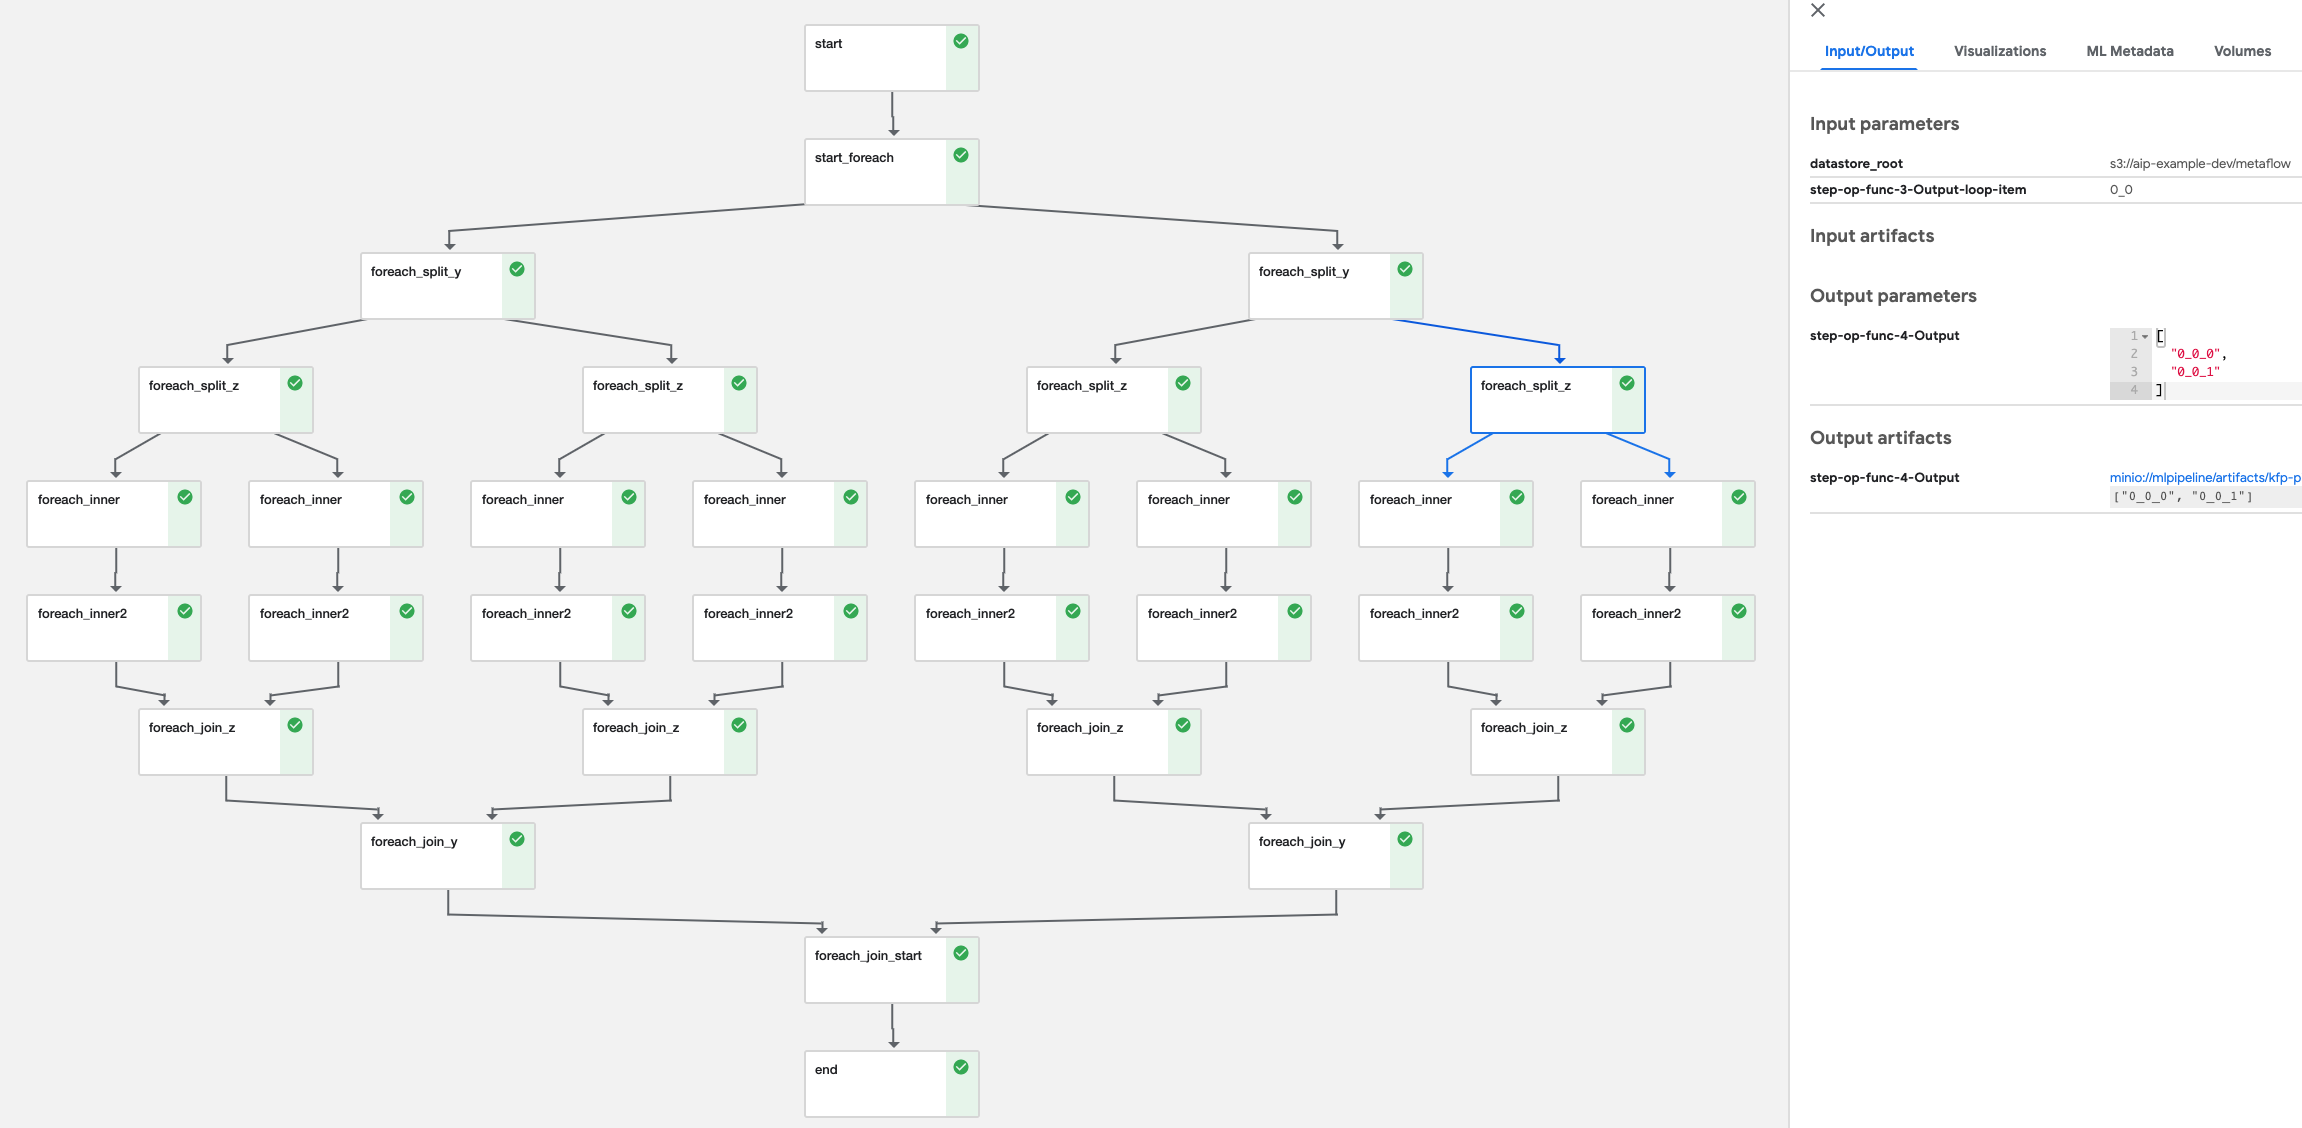

### Highlighting an inner node of foreach with a `passed_in_split_indexes` input to work on


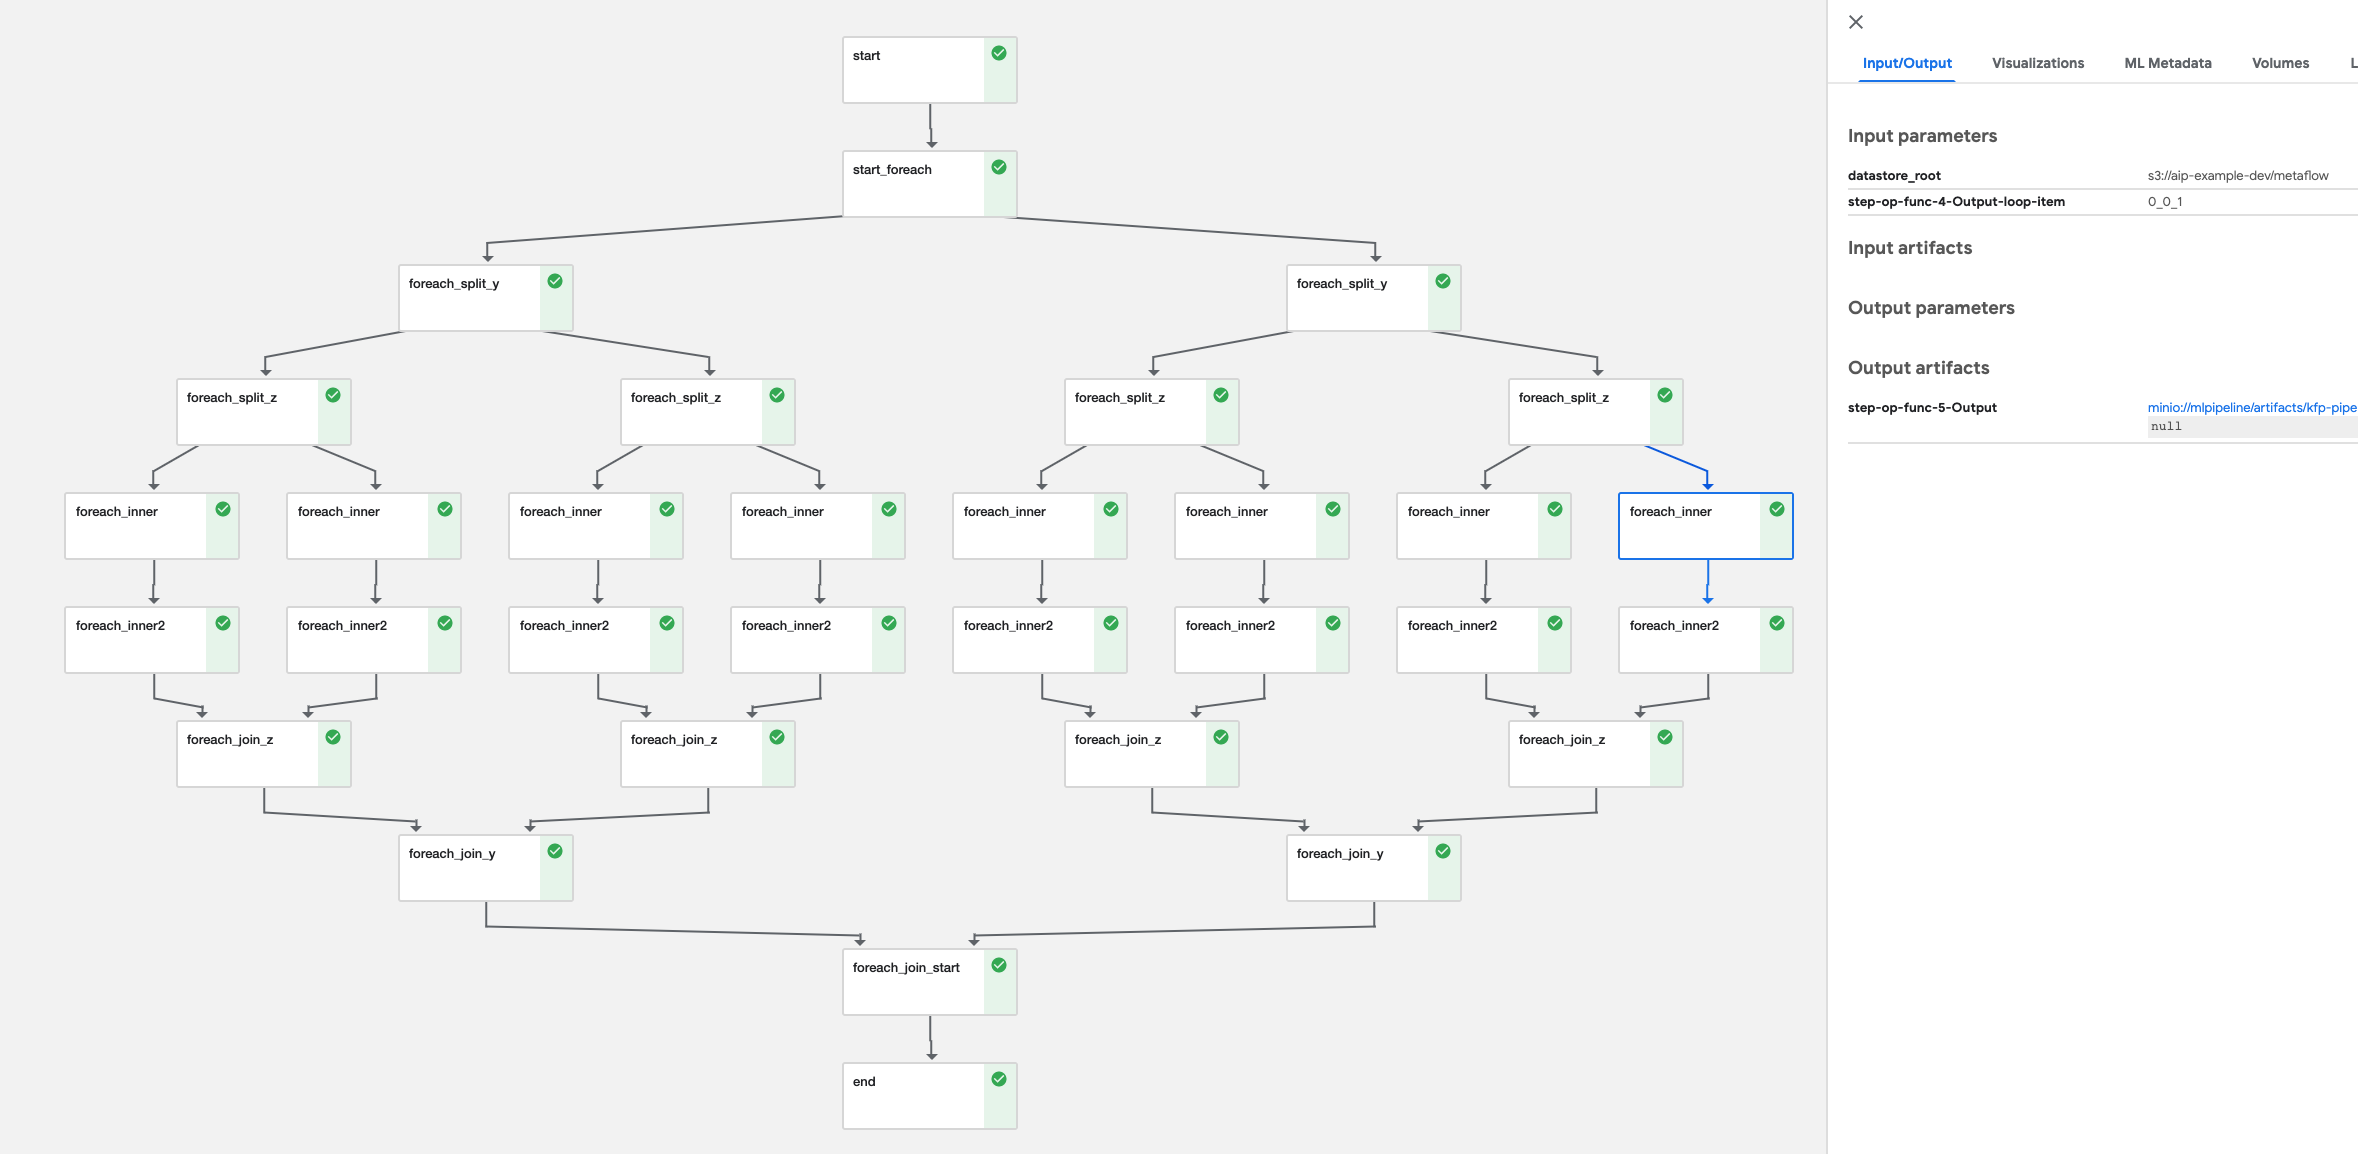